In [2]:
# !pip install git+https://github.com/ClimateImpactLab/xclim@63023d27f89a457c752568ffcec2e9ce9ad7a81a

In [3]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os 
import gcsfs 
from matplotlib import cm
import warnings 

from science_validation_manual import *

In [4]:
from xclim import sdba, set_options
from xclim.sdba.utils import equally_spaced_nodes

In [5]:
ref = read_gcs_zarr('gs://scratch-170cd6ec/643c4b73-399d-427a-87be-cc0ab1b401d9/e2e-bcc-csm2-mr-dtr-qxg22-2721721062/rechunked.zarr')
hist = read_gcs_zarr('gs://scratch-170cd6ec/643c4b73-399d-427a-87be-cc0ab1b401d9/e2e-bcc-csm2-mr-dtr-qxg22-1083920341/thresholded.zarr')
sim = read_gcs_zarr('gs://scratch-170cd6ec/643c4b73-399d-427a-87be-cc0ab1b401d9/e2e-bcc-csm2-mr-dtr-qxg22-3490169582/thresholded.zarr')
bc = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/dtr/gn/v20211230093107.zarr')

In [6]:
# define off the rails lat/lon 
target_lat = 70.5
target_lon = 41.5

# QDM model specs
quantiles_n = 100
window_n = 31

In [7]:
ref_dtr = ref['dtr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
hist_dtr = hist['dtr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
bc_dtr = bc['dtr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()

In [8]:
ref_dtr

<xarray.DataArray 'dtr' (time: 8030)>
array([2.113218 , 0.5102891, 0.6842078, ..., 1.49745  , 1.3983101,
       1.0495324], dtype=float32)
Coordinates:
    lat      float64 70.5
    lon      float64 41.5
  * time     (time) object 1994-01-01 00:00:00 ... 2015-12-31 00:00:00
Attributes:
    coordinates:  dayofyear
    units:        K

In [9]:
sim_slice = sim.sel(lon=target_lon, lat=target_lat, method="nearest").load()

In [28]:
ref_dtr_timeslice = ref_dtr.sel(time=slice("1994-12-17", "2014-12-31"))
hist_dtr_timeslice = hist_dtr.sel(time=slice("1994-12-17", "2014-12-31"))

In [72]:
qdm_extrapolate = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_dtr_timeslice,
        hist=hist_dtr_timeslice,
        kind='*',
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=equally_spaced_nodes(int(quantiles_n), eps=None),
    )

In [73]:
qdm_NO_extrapolate = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_dtr_timeslice,
        hist=hist_dtr_timeslice,
        kind='*',
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=quantiles_n,
    )

In [121]:
qdm_NO_extrapolate_timeslice = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_dtr_timeslice,
        hist=hist_dtr_timeslice,
        kind='*',
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=equally_spaced_nodes(int(quantiles_n), eps=1e-09),
    )

In [122]:
# dtr_sim = sim_slice['dtr'].sel(time=slice("1959-12-17", "1979"))

dtr_sim = sim_slice['dtr'].sel(time=slice("1960-12-17", "1980-12-31"))

In [123]:
print(len(ref_dtr_timeslice))
print(len(hist_dtr_timeslice))
print(len(ref_dtr))
print(len(hist_dtr))
print(len(dtr_sim))

7315
7315
8030
7315
7315


In [124]:
bc_extrapolate_here = qdm_extrapolate.adjust(dtr_sim)

bc_NO_extrapolate_here = qdm_NO_extrapolate.adjust(dtr_sim)

bc_NO_extrapolate_here_timeslice = qdm_NO_extrapolate_timeslice.adjust(dtr_sim)

Text(0.5, 1.0, 'bias corrected, notebook, \n time slicing updated, \n nquantiles updated')

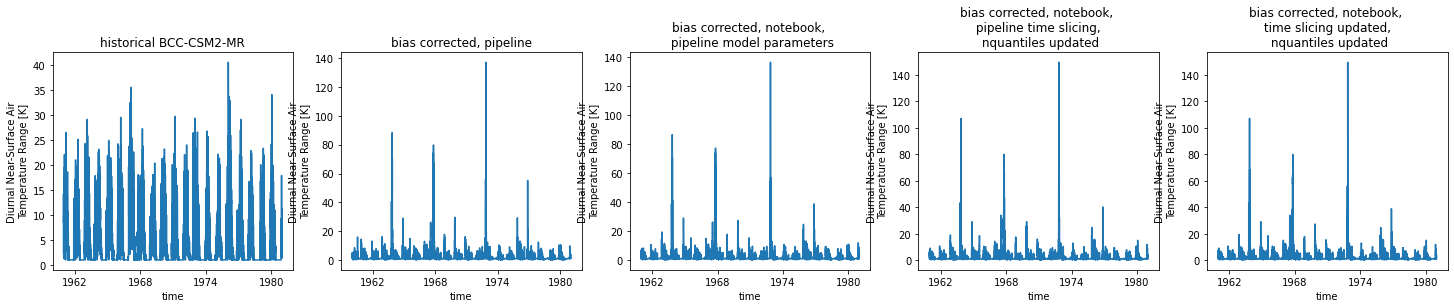

In [125]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))
dtr_sim.plot(ax=axes[0])
axes[0].set_title('historical BCC-CSM2-MR')

bc_dtr.sel(time=slice("1960", "1980")).plot(ax=axes[1])
axes[1].set_title('bias corrected, pipeline')

bc_extrapolate_here.plot(ax=axes[2])
axes[2].set_title('bias corrected, notebook, \n pipeline model parameters')

bc_NO_extrapolate_here.plot(ax=axes[3])
axes[3].set_title('bias corrected, notebook, \n pipeline time slicing, \n nquantiles updated')

bc_NO_extrapolate_here_timeslice.plot(ax=axes[4])
axes[4].set_title('bias corrected, notebook, \n time slicing updated, \n nquantiles updated')

In [126]:
print(bc_NO_extrapolate_here_timeslice[4340].values)
print(dtr_sim[4340].values)

149.6239
26.425629


(0.0, 6.0)

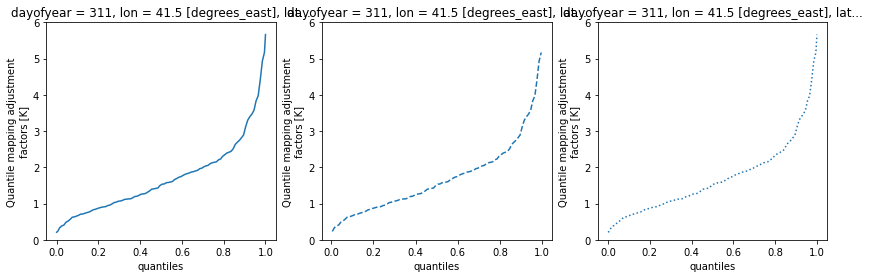

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
qdm_NO_extrapolate.ds.af.sel(dayofyear=311).plot(ax=axes[0], linestyle='-')
axes[0].set_ylim([0, 6])
qdm_extrapolate.ds.af.sel(dayofyear=311).plot(ax=axes[1],linestyle='--')
qdm_NO_extrapolate_timeslice.ds.af.sel(dayofyear=311).plot(ax=axes[2],linestyle=':')
axes[1].set_ylim([0, 6])
axes[2].set_ylim([0, 6])